# Classically-Boosted Variational Quantum Eigensolver

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
from pennylane import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg

In [18]:
# Define the molecular Hamiltonian
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
basis_set = "sto-3g"
electrons = 2
orbitals = 2
stepsize = 0.4
# Set the number of iterations and the convergence
max_iterations = 50

Hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

# Define the HF initial state
hf = qml.qchem.hf_state(electrons, qubits)

# Define all possible single and double excitations
singles, doubles = qml.qchem.excitations(electrons=electrons, orbitals=qubits)
num_theta = len(singles) + len(doubles)

---VQE for num. of samples 500---
Step = 0,  Energy = -1.12703553 Ha
Step = 2,  Energy = -1.13503646 Ha
Step = 4,  Energy = -1.13037470 Ha
Step = 6,  Energy = -1.14539676 Ha
Step = 8,  Energy = -1.13922814 Ha
Step = 10,  Energy = -1.14553049 Ha
Step = 12,  Energy = -1.13514071 Ha
Step = 14,  Energy = -1.12387015 Ha
Step = 16,  Energy = -1.14058417 Ha
Step = 18,  Energy = -1.14230203 Ha

Final value of the ground-state energy = -1.13631773 Ha

Optimal values of the circuit parameter =,  [ 0.00748388 -0.01525677  0.20961695]
---VQE for num. of samples 600---
Step = 0,  Energy = -1.12749656 Ha
Step = 2,  Energy = -1.13695951 Ha
Step = 4,  Energy = -1.13358770 Ha
Step = 6,  Energy = -1.13965310 Ha
Step = 8,  Energy = -1.13403841 Ha
Step = 10,  Energy = -1.12907083 Ha
Step = 12,  Energy = -1.13998254 Ha
Step = 14,  Energy = -1.13907787 Ha
Step = 16,  Energy = -1.12974905 Ha
Step = 18,  Energy = -1.13033068 Ha

Final value of the ground-state energy = -1.12279935 Ha

Optimal values of the ci

/tmp/ipykernel_9556/1017421259.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,7))


Step = 0,  Energy = -1.12531800 Ha
Step = 2,  Energy = -1.13609763 Ha
Step = 4,  Energy = -1.13404907 Ha
Step = 6,  Energy = -1.13583980 Ha
Step = 8,  Energy = -1.13791411 Ha
Step = 10,  Energy = -1.13122139 Ha
Step = 12,  Energy = -1.13647626 Ha
Step = 14,  Energy = -1.13858895 Ha
Step = 16,  Energy = -1.13599582 Ha
Step = 18,  Energy = -1.13518180 Ha

Final value of the ground-state energy = -1.13495372 Ha

Optimal values of the circuit parameter =,  [ 0.00454135 -0.00446364  0.20740077]
---VQE for num. of samples 2700---
Step = 0,  Energy = -1.12777891 Ha
Step = 2,  Energy = -1.13485259 Ha
Step = 4,  Energy = -1.13628058 Ha
Step = 6,  Energy = -1.13477292 Ha
Step = 8,  Energy = -1.13494272 Ha
Step = 10,  Energy = -1.13826910 Ha
Step = 12,  Energy = -1.13918855 Ha
Step = 14,  Energy = -1.13770284 Ha
Step = 16,  Energy = -1.13967265 Ha
Step = 18,  Energy = -1.13310264 Ha

Final value of the ground-state energy = -1.13746558 Ha

Optimal values of the circuit parameter =,  [-0.00599448 

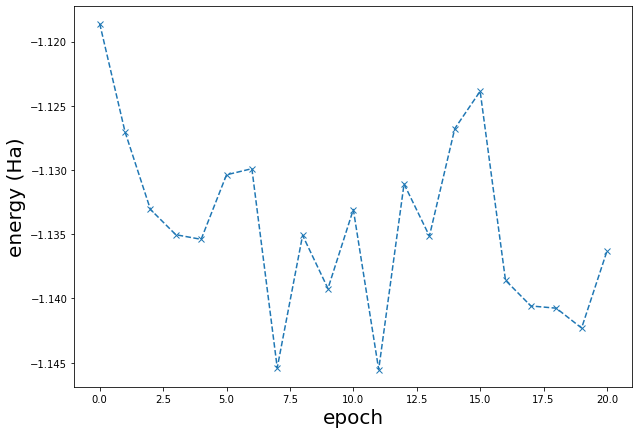

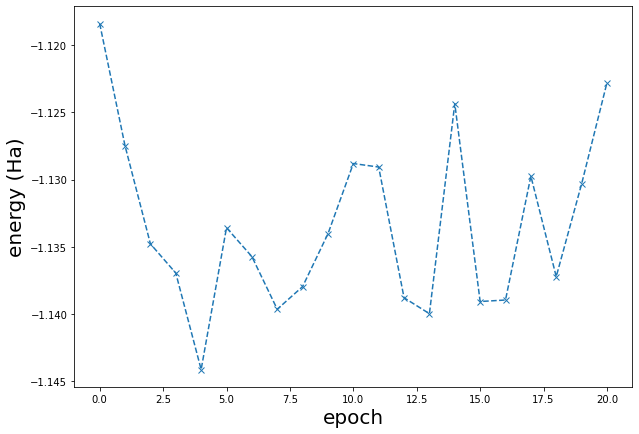

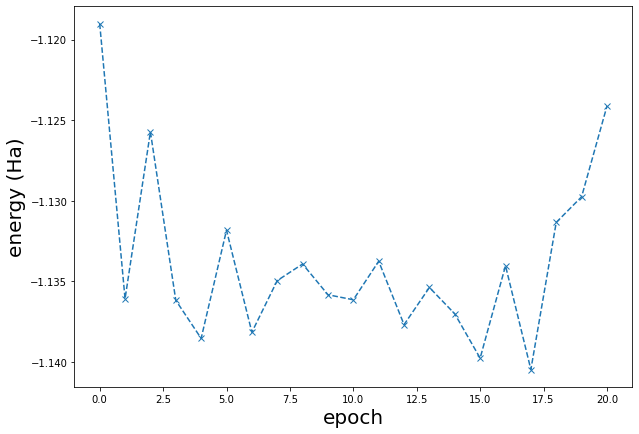

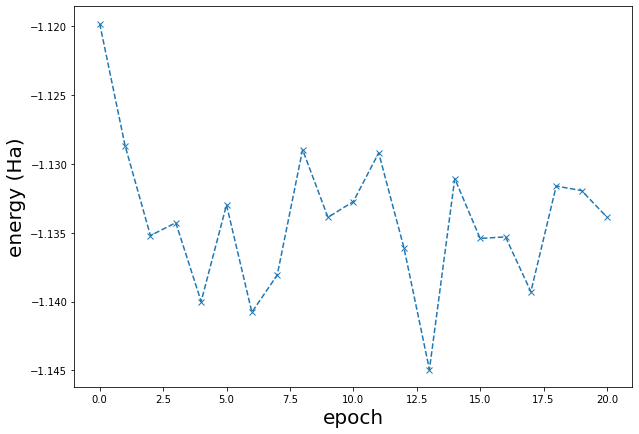

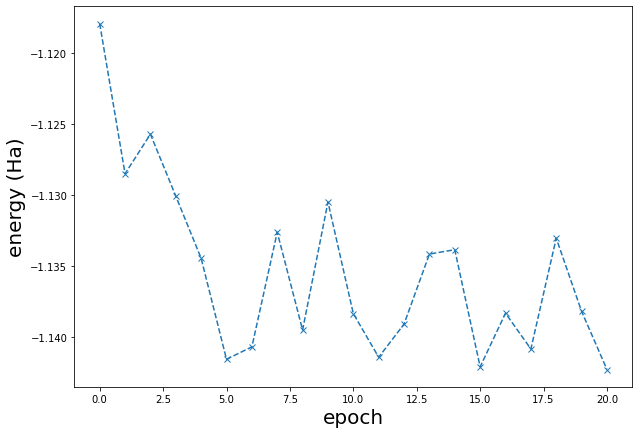

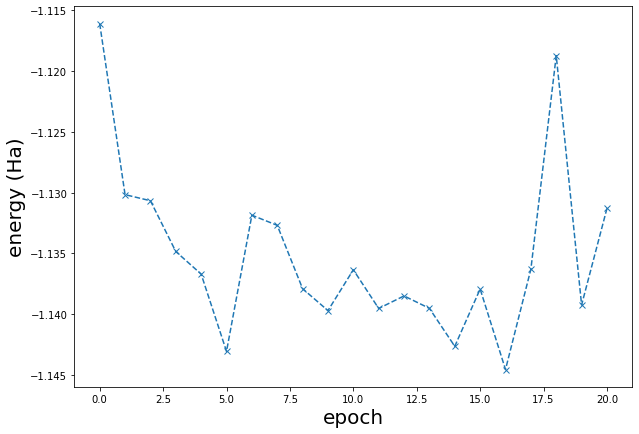

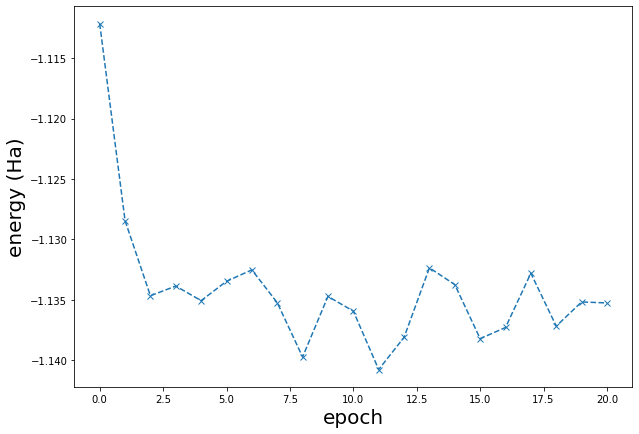

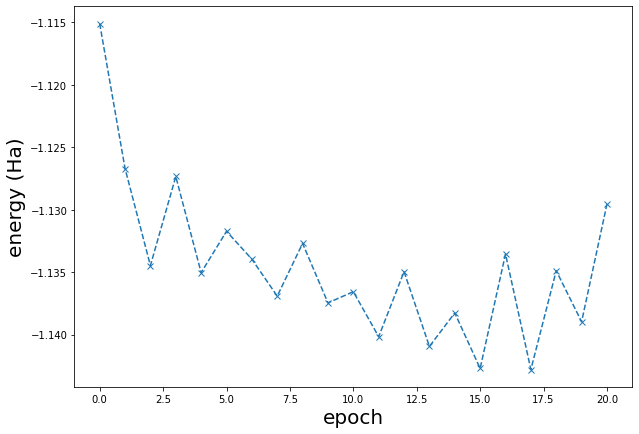

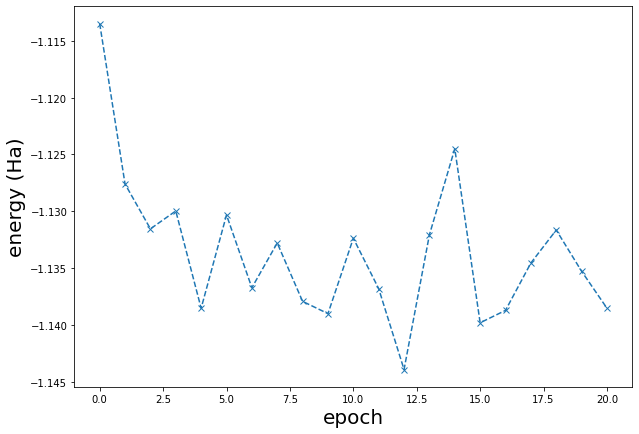

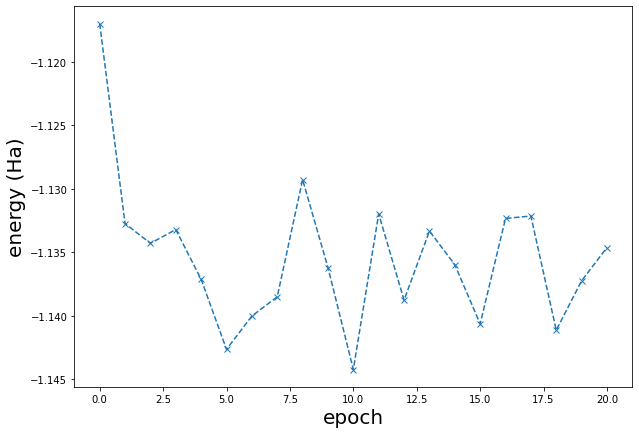

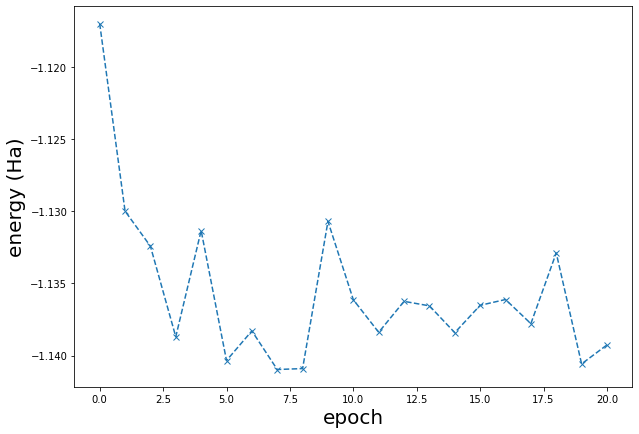

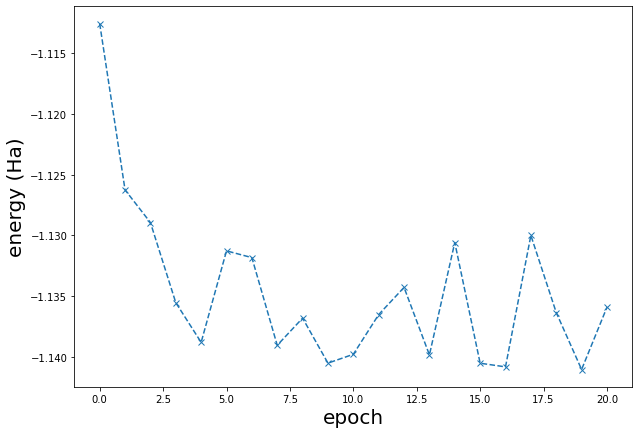

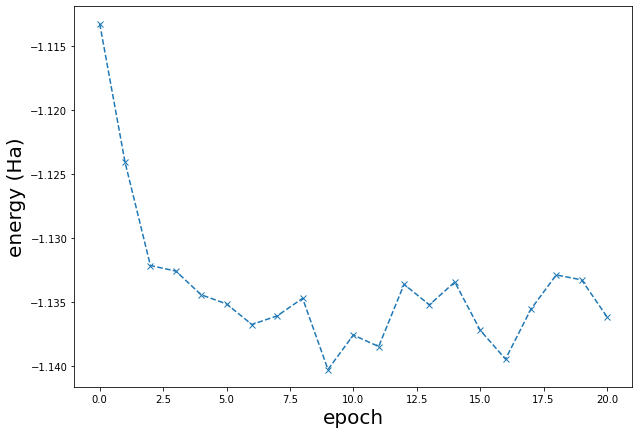

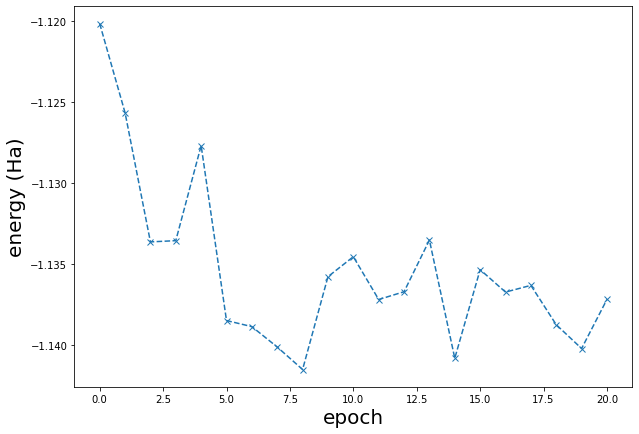

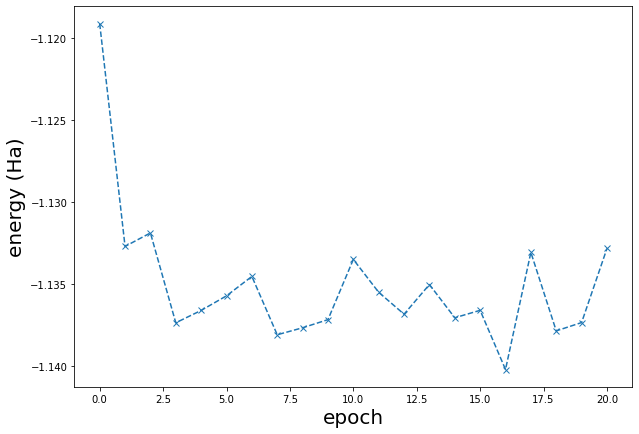

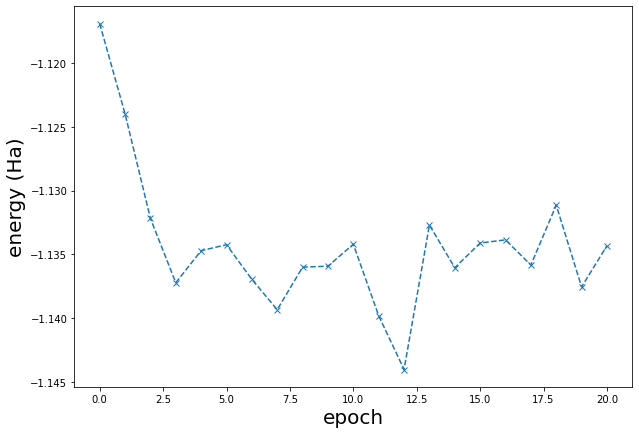

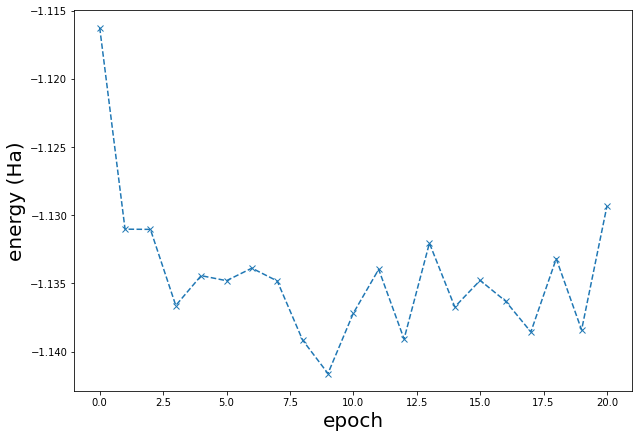

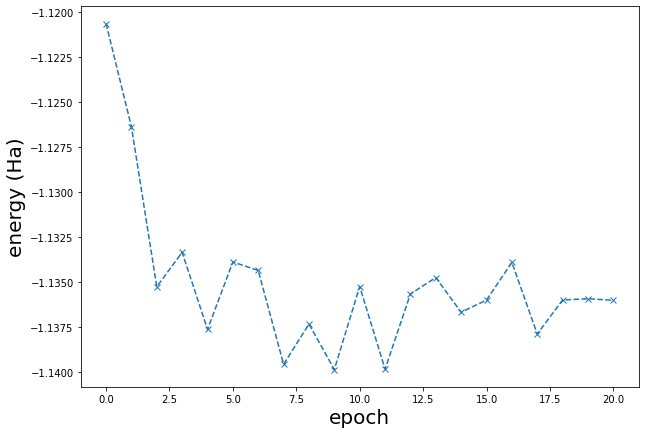

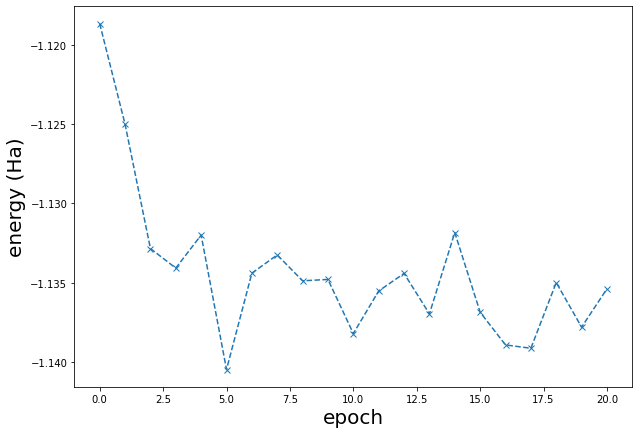

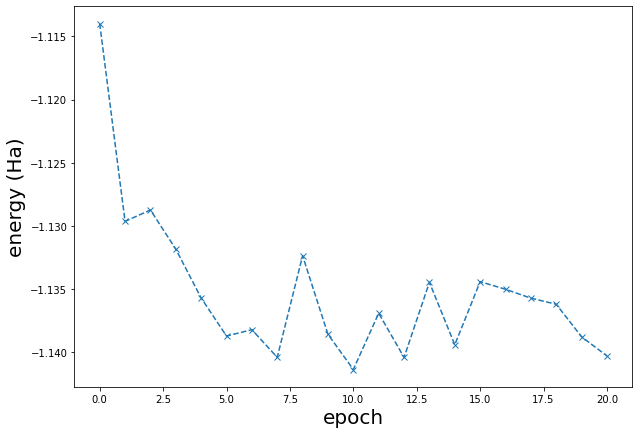

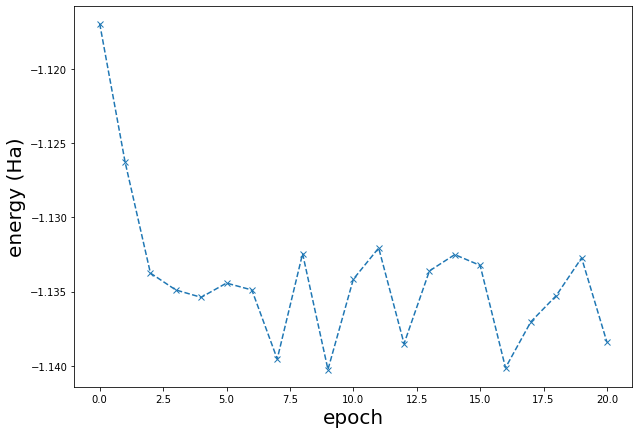

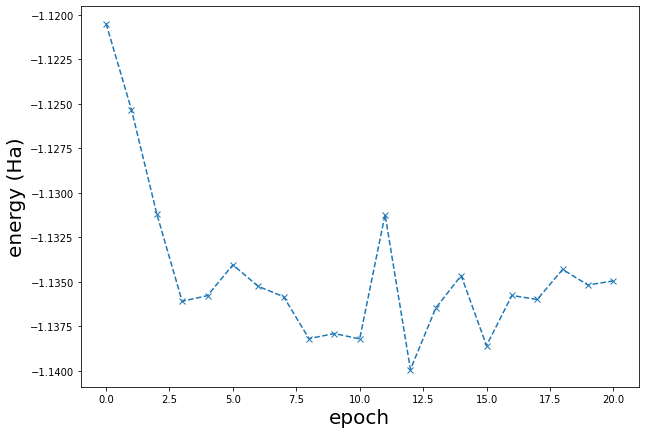

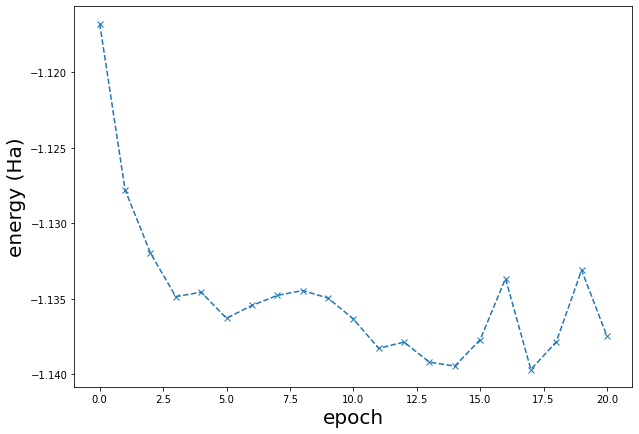

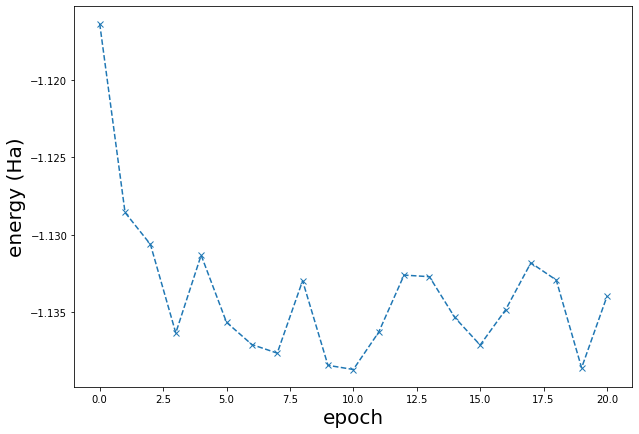

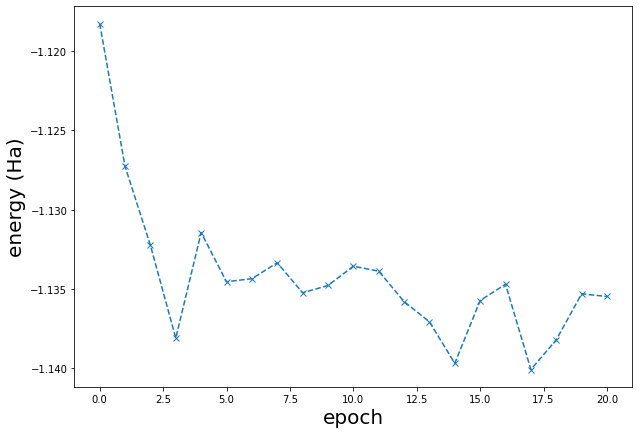

In [5]:
num_shots_list = np.arange(500,3000,100)
energies_VQE = []
angles_VQE = []

# Define the cost function and the circuit
def circuit_VQE(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf,
        singles = singles,
        doubles = doubles)
        
for num_shots in num_shots_list:
    
    print('---VQE for num. of samples %.0f---' %num_shots)
    
    num_shots = int(num_shots)

    # Define a device
    dev = qml.device('default.qubit', wires=qubits, shots=num_shots)

    @qml.qnode(dev)
    def cost_fn(theta):
        circuit_VQE(theta,range(qubits)) # Why define outside?
        return qml.expval(Hamiltonian)

    # Draw circuit
    # qml.drawer.use_style('black_white')
    # qml.draw_mpl(cost_fn, expansion_strategy="device")(np.zeros(num_theta))

    # Gradient descent optimization
    opt = qml.GradientDescentOptimizer(stepsize=stepsize)
    theta = np.zeros(num_theta, requires_grad=True)

    #  Initial energy
    energy = [cost_fn(theta)]
    angle = [theta]

    for n in range(max_iterations):

        theta, prev_energy = opt.step_and_cost(cost_fn, theta)

        energy.append(cost_fn(theta))
        angle.append(theta)

        conv = np.abs(energy[-1] - prev_energy)

        if n % 2 == 0:
            print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
    print("\n" f"Optimal values of the circuit parameter =, ", angle[-1])

    plt.figure(figsize=(10,7))
    plt.plot(energy ,"x--")
    plt.xlabel("epoch", fontsize=20)
    plt.ylabel("energy (Ha)", fontsize=20)
    
    energies_VQE.append(energy[-1])
    angles_VQE.append(angle[-1])

In [13]:
def circuit_product_state(occupation):
    
    occupation = np.array(occupation)
    occupied_wires = list(np.where(occupation == 1)[0])
    unoccupied_wires = list(np.where(occupation == 0)[0])
    
    for wire in occupied_wires:
        qml.PauliX(wires=wire)    
    for wire in unoccupied_wires:
        qml.Identity(wires=wire)

dev = qml.device("default.qubit", wires=range(qubits))
                         
@qml.qnode(dev)
def HF_energy():
    circuit_product_state([1,1,0,0]) 
    return qml.expval(Hamiltonian)
    
H11 = HF_energy()

In [14]:
energies_CBVQE = []
    
for i, num_shots in enumerate(num_shots_list):

    # GET VQE energy
    H22 = energies_VQE[i]
    theta_opt = angles_VQE[i]
    
    # Get crossed terms
    wires = range(qubits + 1)
    dev = qml.device("default.qubit", wires=wires, shots=int(num_shots))
    Vcl = np.identity(2**qubits)
    Vq = qml.matrix(circuit_VQE)(theta_opt, range(qubits))

    @qml.qnode(dev)
    def hadamard_test(Vq, Vcl, W, component='real'):

        if component == 'imag':
            qml.RX(math.pi/2, wires=a_wires)

        qml.Hadamard(wires=[0])
        qml.QubitUnitary(W, wires=wires[1:])
        qml.ControlledQubitUnitary(Vq.conjugate().T @ Vcl, control_wires=[0], wires=wires[1:])
        qml.Hadamard(wires=[0])

        return qml.probs(wires=[0])

    H12 = 0
    H_terms = [-1.36588246e+00, -2.00818352e-17, -2.00818352e-17,  2.17927865e-01]
    for i, basis_state in enumerate([[1,1,0,0], [0,1,1,0], [1,0,0,1], [0,0,1,1]]):
        W = qml.matrix(circuit_product_state)(basis_state)
        probs = hadamard_test(Vq, Vcl, W)
        y = 2*abs(probs[0])-1
        H12 += y*H_terms[i]
        if i == 0:
            y0 = y
    
    H21 = np.conjugate(H12)

    S = np.array([[1, y0],[y0, 1]])
    H = np.array([[H11, H12],[H21, H22]])
    
    evals = linalg.eigvals(H, S)
    
    energies_CBVQE.append(np.min(evals))

Text(0, 0.5, 'energy (Ha)')

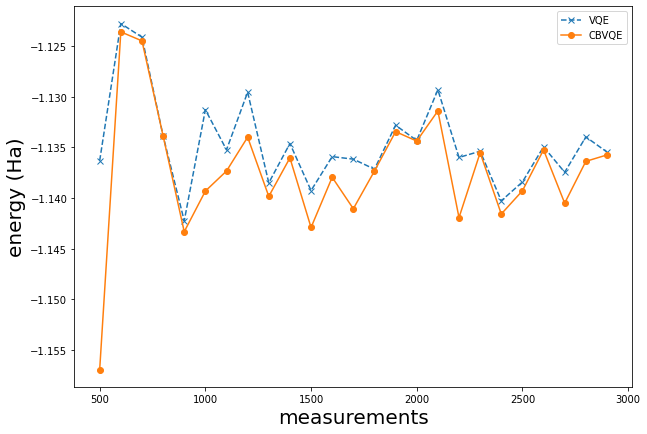

In [15]:
plt.figure(figsize=(10,7))
plt.plot(num_shots_list, energies_VQE,"x--", label='VQE')
plt.plot(num_shots_list, energies_CBVQE,"o-", label='CBVQE')
plt.legend()
plt.xlabel("measurements", fontsize=20)
plt.ylabel("energy (Ha)", fontsize=20)

In [16]:
import sys
sys.path.append('../../ASCI_algorithm/functions/')

import openfermion
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

from ASCI_functions import * 

n_hydrogens = 2
bond_distance = 0.6614*2
bohr_angs = 0.529177210903

system = MolecularData(
        geometry=[('H', (0.0, 0.0, -0.6614)), ('H', (0.0, 0.0, 0.6614))],
        charge=0,
        basis="sto-3g",
        multiplicity=1
)

# Get molecule info
hf = run_pyscf(system, run_scf=False, run_cisd=False)
norbs = hf.n_orbitals
nsorbs = norbs*2
nelec = hf.n_electrons

nrepulsion = getNuclearRepulsion(n_hydrogens, bond_distance, bohr_angs)
# Get HF coefs and 1e/2e integrals
onebody_int, twobody_int = getIntegrals(hf)
Hamiltonian_generator = HamiltonianGenerator(onebody_int, twobody_int)

# Build the HF determinant
HF_det = getHFState(nsorbs, nelec)

# Single and double excitations
dets = computeExcitations(HF_det, [1,2])  
dets = dets[::-1]

print(dets)

# Generate detList (convert to construct the Hamiltonian)
detList = getDetRef(dets)

# Generate Hamiltonian
H = Hamiltonian_generator.generateMatrix(detList)    

print(H)



[[1. 1. 0. 0.]
 [1. 0. 0. 1.]
 [0. 1. 1. 0.]
 [0. 0. 1. 1.]]
[[-1.36588246e+00 -2.27508770e-17 -2.27508770e-17  2.17927865e-01]
 [-2.27508770e-17 -1.04247360e+00  2.17927865e-01 -2.27508770e-17]
 [-2.27508770e-17  2.17927865e-01 -1.04247360e+00 -2.27508770e-17]
 [ 2.17927865e-01 -2.27508770e-17 -2.27508770e-17 -6.96093342e-01]]


In [17]:
Hamiltonian

AttributeError: 'Hamiltonian' object has no attribute 'get_matrix'